In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

In [2]:
def say_something(x):
    """
    Print the current widget value in short sentence
    """
    print(f'Widget says: {x}')
 
widgets.interact(say_something, x=[0, 1, 2, 3])
widgets.interact(say_something, x=(0, 10, 1))
widgets.interact(say_something, x=(0, 10, .5))
_ = widgets.interact(say_something, x=True)

interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3), value=0), Output()), _dom_classes=('widg…

interactive(children=(IntSlider(value=5, description='x', max=10), Output()), _dom_classes=('widget-interact',…

interactive(children=(FloatSlider(value=5.0, description='x', max=10.0, step=0.5), Output()), _dom_classes=('w…

interactive(children=(Checkbox(value=True, description='x'), Output()), _dom_classes=('widget-interact',))

interactive(children=(IntSlider(value=1, description='w', max=10), FloatSlider(value=1.0, description='amp', m…

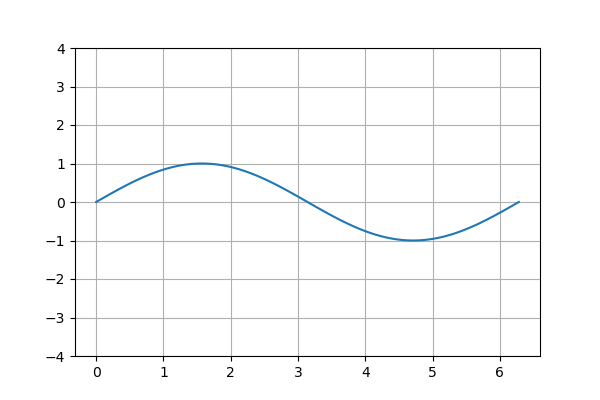

In [3]:
# set up plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# generate x values
x = np.linspace(0, 2 * np.pi, 100)
 
 
def my_sine(x, w, amp, phi):
    """
    Return a sine for x with angular frequeny w and amplitude amp.
    """
    return amp*np.sin(w * (x-phi))
 
 
@widgets.interact(w=(0, 10, 1), amp=(0, 4, .1), phi=(0, 2*np.pi+0.01, 0.01))
def update(w = 1.0, amp=1, phi=0):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    ax.plot(x, my_sine(x, w, amp, phi), color='C0')

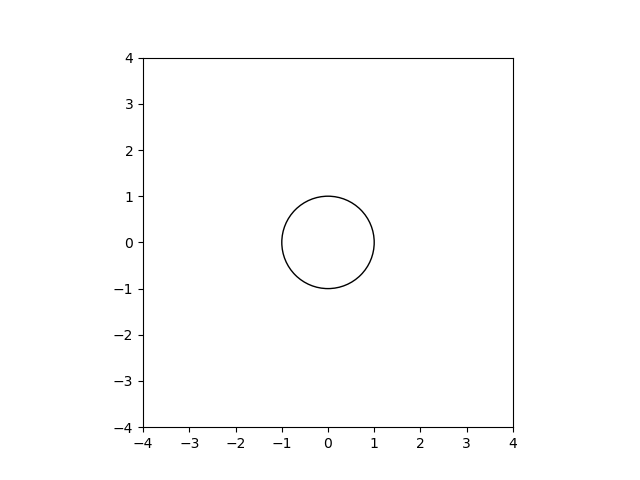

In [4]:
fig, ax = plt.subplots()
ax.set_ylim([-4, 4])
ax.set_xlim([-4, 4])
ax.grid(False)
ax.set_aspect(1)
rad=1
accept_radii = Circle((0,0),rad, fill=False)

ax.add_artist(accept_radii);